# 深度算子网络(DeepONet)求解Burgers方程

本notebook实现了标准的DeepONet架构用于求解Burgers方程。
与物理信息版本不同，这里采用纯监督学习方法，完全基于数据驱动训练网络。

DeepONet能够学习从函数到函数的映射，即：$G: \mathcal{U} \rightarrow \mathcal{V}$
其中$\mathcal{U}$和$\mathcal{V}$分别是输入和输出函数空间。

对于Burgers方程：
- 输入：初始条件函数 $u_0(x)$
- 输出：解函数 $u(x,t)$

## 1. 导入必要的库

导入PyTorch、NumPy、SciPy等必要的深度学习和科学计算库。

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

## 2. 定义多层感知机(MLP)网络

创建通用的多层感知机类，用于构建DeepONet的分支网络和主干网络。

In [36]:
class MultiLayerPerceptron(nn.Module):
    """
    多层感知机网络
    
    Args:
        input_dim: 输入维度
        output_dim: 输出维度
        hidden_dim: 隐藏层维度
        num_hidden_layers: 隐藏层数量
        activation: 激活函数类型
    """
    
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers, activation=nn.Tanh):
        super().__init__()

        # 构建网络结构
        layers = []
        
        # 输入层
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation())

        # 隐藏层
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation())

        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """使用Xavier正态分布初始化权重"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.model(x)

## 3. 实现标准DeepONet架构

构建DeepONet网络，包含分支网络(处理函数输入)和主干网络(处理坐标输入)。

In [37]:
class DeepONet(nn.Module):
    """
    标准深度算子网络(DeepONet)
    
    DeepONet包含两个主要组件：
    - 分支网络(Branch Network): 处理函数输入(如初始条件)
    - 主干网络(Trunk Network): 处理坐标输入(如时空点)
    
    最终输出通过点积操作组合两个网络的输出：
    G(u)(y) = Σᵢ bᵢ(u) * tᵢ(y) + b₀
    """
    
    def __init__(self, 
                 branch_input_dim=101,   # 初始条件维度
                 trunk_input_dim=2,      # 时空坐标维度
                 hidden_dim=100,         # 隐藏层维度
                 num_hidden_layers=6,    # 隐藏层数
                 output_dim=100):        # 特征输出维度
        super().__init__()

        # 分支网络：处理函数输入(初始条件)
        self.branch_network = MultiLayerPerceptron(
            input_dim=branch_input_dim,
            output_dim=output_dim,
            hidden_dim=hidden_dim,
            num_hidden_layers=num_hidden_layers
        )
        
        # 主干网络：处理坐标输入(时空点)
        self.trunk_network = MultiLayerPerceptron(
            input_dim=trunk_input_dim,
            output_dim=output_dim,
            hidden_dim=hidden_dim,
            num_hidden_layers=num_hidden_layers
        )
        
        # 偏置项
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, function_input, coordinate_input):
        """
        前向传播
        
        Args:
            function_input: 函数输入 [batch_size, function_dim]
            coordinate_input: 坐标输入 [batch_size, coordinate_dim]
        
        Returns:
            output: 网络输出 [batch_size, 1]
        """
        # 分支网络输出
        branch_output = self.branch_network(function_input)  # [batch_size, output_dim]
        
        # 主干网络输出
        trunk_output = self.trunk_network(coordinate_input)   # [batch_size, output_dim]
        
        # 点积操作 + 偏置项
        output = torch.sum(branch_output * trunk_output, dim=1, keepdim=True) + self.bias
        
        return output

## 4. 实现数据加载器

创建专门的数据加载器，处理Burgers方程的训练数据，准备监督学习所需的输入-输出对。

In [38]:
class BurgersDataLoader:
    """
    Burgers方程数据加载器 - 监督学习版本
    
    准备DeepONet训练所需的输入-输出对：
    - 输入: (初始条件, 时空坐标)
    - 输出: 对应的解值
    """
    
    def __init__(self, data_path='/home/yc/DeepONet/PI-DeepONet/burger_nu_0.001.mat'):
        self.data_path = data_path
        self._load_and_prepare_data()

    def _load_and_prepare_data(self):
        """加载和预处理数据"""
        print("Loading Burgers equation dataset...")
        
        # 加载原始数据
        data = scipy.io.loadmat(self.data_path)
        initial_conditions = data['input']  # [n_samples, 101]
        solutions = data['output']          # [n_samples, 101, 101]
        
        # 创建时空网格
        t_coords = np.linspace(0, 1, 101)
        x_coords = np.linspace(0, 1, 101)
        T, X = np.meshgrid(t_coords, x_coords, indexing='ij')
        
        self.t_grid = T  # [101, 101]
        self.x_grid = X  # [101, 101]
        
        # 将网格展平为坐标对
        self.coordinates = np.column_stack([
            T.flatten(),  # 时间坐标
            X.flatten()   # 空间坐标
        ])  # [10201, 2]
        
        # 准备训练数据 (前1000个样本)
        n_train = 1000
        self.train_initial_conditions = initial_conditions[:n_train]  # [1000, 101]
        self.train_solutions = solutions[:n_train].reshape(n_train, -1)  # [1000, 10201]
        
        # 准备测试数据 (1600-1800样本)
        test_start, test_end = 1600, 1800
        self.test_initial_conditions = initial_conditions[test_start:test_end]  # [200, 101]
        self.test_solutions = solutions[test_start:test_end].reshape(test_end-test_start, -1)  # [200, 10201]
        
        print(f"Training samples: {n_train}")
        print(f"Test samples: {test_end-test_start}")
        print(f"Grid points per sample: {len(self.coordinates)}")

    def create_training_pairs(self, n_points_per_sample=1000):
        """
        创建训练数据对
        
        Args:
            n_points_per_sample: 每个样本随机选择的点数
        
        Returns:
            initial_conditions: 初始条件 [N, 101]
            coordinates: 时空坐标 [N, 2]
            solutions: 对应的解值 [N, 1]
        """
        n_train_samples = len(self.train_initial_conditions)
        n_total_points = n_train_samples * n_points_per_sample
        
        # 预分配数组
        initial_conditions = np.zeros((n_total_points, 101))
        coordinates = np.zeros((n_total_points, 2))
        solutions = np.zeros((n_total_points, 1))
        
        # 为每个训练样本生成数据对
        for i in range(n_train_samples):
            # 随机选择时空点
            point_indices = np.random.choice(
                len(self.coordinates), 
                size=n_points_per_sample, 
                replace=False
            )
            
            start_idx = i * n_points_per_sample
            end_idx = (i + 1) * n_points_per_sample
            
            # 填充数据
            initial_conditions[start_idx:end_idx] = self.train_initial_conditions[i]
            coordinates[start_idx:end_idx] = self.coordinates[point_indices]
            solutions[start_idx:end_idx, 0] = self.train_solutions[i, point_indices]
        
        return initial_conditions, coordinates, solutions

    def get_test_data(self, sample_index):
        """
        获取特定测试样本的完整数据
        
        Args:
            sample_index: 测试样本索引
        
        Returns:
            initial_condition: 初始条件 [10201, 101]
            coordinates: 全部时空坐标 [10201, 2]
            true_solution: 真实解 [10201, 1]
        """
        n_points = len(self.coordinates)
        
        # 复制初始条件到所有时空点
        initial_condition = np.tile(
            self.test_initial_conditions[sample_index], 
            (n_points, 1)
        )
        
        # 获取对应的真实解
        true_solution = self.test_solutions[sample_index].reshape(-1, 1)
        
        return initial_condition, self.coordinates, true_solution

## 5. 实现DeepONet训练器

构建完整的训练框架，包含损失函数、优化器和训练循环。

In [39]:
class DeepONetTrainer:
    """
    DeepONet训练器
    
    使用纯监督学习方法训练DeepONet模型。
    """
    
    def __init__(self, 
                 branch_input_dim=101,
                 trunk_input_dim=2,
                 hidden_dim=100,
                 num_hidden_layers=6,
                 output_dim=100,
                 learning_rate=1e-3,
                 device=None):
        
        # 设备配置
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        print(f"Using device: {self.device}")

        # 初始化网络
        self.model = DeepONet(
            branch_input_dim=branch_input_dim,
            trunk_input_dim=trunk_input_dim,
            hidden_dim=hidden_dim,
            num_hidden_layers=num_hidden_layers,
            output_dim=output_dim
        )
        self.model.to(self.device)

        # 优化器设置 - 调整学习率衰减因子以适应更长的训练
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.98)

        # 损失函数
        self.criterion = nn.MSELoss()

        # 数据加载器
        self.data_loader = BurgersDataLoader()

        # 训练历史
        self.loss_history = []
        self.lr_history = []

    def _to_device(self, *tensors):
        """将张量移动到指定设备"""
        result = []
        for tensor in tensors:
            if isinstance(tensor, np.ndarray):
                tensor = torch.FloatTensor(tensor)
            result.append(tensor.to(self.device))
        return result if len(result) > 1 else result[0]

    def train_step(self, initial_conditions, coordinates, true_solutions):
        """
        执行一步训练
        
        Args:
            initial_conditions: 初始条件 [batch_size, 101]
            coordinates: 时空坐标 [batch_size, 2] 
            true_solutions: 真实解 [batch_size, 1]
        
        Returns:
            loss: 训练损失
        """
        self.model.train()
        
        # 数据移动到设备
        initial_conditions, coordinates, true_solutions = self._to_device(
            initial_conditions, coordinates, true_solutions
        )
        
        # 前向传播
        predictions = self.model(initial_conditions, coordinates)
        
        # 计算损失
        loss = self.criterion(predictions, true_solutions)
        
        # 反向传播
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    def evaluate(self, sample_index=0):
        """
        评估模型在测试样本上的性能
        
        Args:
            sample_index: 测试样本索引
        
        Returns:
            relative_l2_error: 相对L2误差
        """
        self.model.eval()
        
        with torch.no_grad():
            # 获取测试数据
            initial_conditions, coordinates, true_solutions = self.data_loader.get_test_data(sample_index)
            
            # 数据移动到设备
            initial_conditions, coordinates = self._to_device(initial_conditions, coordinates)
            
            # 预测
            predictions = self.model(initial_conditions, coordinates)
            predictions = predictions.cpu().numpy()
            
            # 计算相对L2误差
            relative_error = (
                np.linalg.norm(predictions - true_solutions) / 
                np.linalg.norm(true_solutions)
            )
            
        return relative_error

    def train(self, 
              num_epochs=100, 
              batch_size=10000, 
              points_per_sample=1000,
              eval_interval=10,
              lr_decay_interval=20):
        """
        训练模型
        
        Args:
            num_epochs: 训练轮数
            batch_size: 批量大小
            points_per_sample: 每个样本选择的点数
            eval_interval: 评估间隔
            lr_decay_interval: 学习率衰减间隔
        """
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Batch size: {batch_size}, Points per sample: {points_per_sample}")
        
        start_time = time.time()
        
        for epoch in range(1, num_epochs + 1):
            # 生成训练数据
            initial_conditions, coordinates, solutions = self.data_loader.create_training_pairs(
                n_points_per_sample=points_per_sample
            )
            
            # 随机打乱数据
            n_total = len(initial_conditions)
            indices = np.random.permutation(n_total)
            
            epoch_losses = []
            
            # 批量训练
            for i in range(0, n_total, batch_size):
                batch_indices = indices[i:i+batch_size]
                
                batch_ics = initial_conditions[batch_indices]
                batch_coords = coordinates[batch_indices]
                batch_sols = solutions[batch_indices]
                
                loss = self.train_step(batch_ics, batch_coords, batch_sols)
                epoch_losses.append(loss)
            
            # 记录平均损失
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            self.lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            # 打印进度
            if epoch % eval_interval == 0 or epoch == 1:
                rel_error = self.evaluate(sample_index=0)
                print(f"Epoch {epoch:4d}: Loss = {avg_loss:.4e}, "
                      f"Rel. L2 Error = {rel_error:.4e}, "
                      f"LR = {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # 学习率衰减
            if epoch % lr_decay_interval == 0:
                self.scheduler.step()
        
        end_time = time.time()
        print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

    def save_model(self, filepath):
        """保存模型"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
            'lr_history': self.lr_history
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """加载模型"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_history = checkpoint.get('loss_history', [])
        self.lr_history = checkpoint.get('lr_history', [])
        print(f"Model loaded from {filepath}")

## 6. 训练DeepONet模型

使用监督学习方法训练DeepONet模型。

In [40]:
# 创建训练器
trainer = DeepONetTrainer(
    branch_input_dim=101,
    trunk_input_dim=2,
    hidden_dim=100,
    num_hidden_layers=6,
    output_dim=100,
    learning_rate=1e-3
)

# 开始训练
trainer.train(
    num_epochs=1000,
    batch_size=8000,
    points_per_sample=1000,
    eval_interval=20,
    lr_decay_interval=100
)

Using device: cuda
Loading Burgers equation dataset...
Training samples: 1000
Test samples: 200
Grid points per sample: 10201
Starting training for 1000 epochs...
Batch size: 8000, Points per sample: 1000
Epoch    1: Loss = 3.5130e-02, Rel. L2 Error = 9.4266e-01, LR = 1.00e-03
Epoch   20: Loss = 3.4153e-03, Rel. L2 Error = 2.3090e-01, LR = 1.00e-03
Epoch   40: Loss = 8.2955e-03, Rel. L2 Error = 3.1852e-01, LR = 1.00e-03
Epoch   60: Loss = 5.1789e-03, Rel. L2 Error = 2.7007e-01, LR = 1.00e-03
Epoch   80: Loss = 3.3200e-03, Rel. L2 Error = 2.3503e-01, LR = 1.00e-03
Epoch  100: Loss = 2.2082e-03, Rel. L2 Error = 1.8707e-01, LR = 1.00e-03
Epoch  120: Loss = 1.7259e-03, Rel. L2 Error = 1.5998e-01, LR = 9.80e-04
Epoch  140: Loss = 2.4668e-02, Rel. L2 Error = 7.4374e-01, LR = 9.80e-04
Epoch  160: Loss = 8.3330e-03, Rel. L2 Error = 3.6425e-01, LR = 9.80e-04
Epoch  180: Loss = 6.6744e-03, Rel. L2 Error = 3.4719e-01, LR = 9.80e-04
Epoch  200: Loss = 3.0115e-03, Rel. L2 Error = 2.5333e-01, LR = 9

## 7. 保存训练结果

保存训练好的模型和训练历史。

Model saved to ./deeponet_results/deeponet_burgers.pth


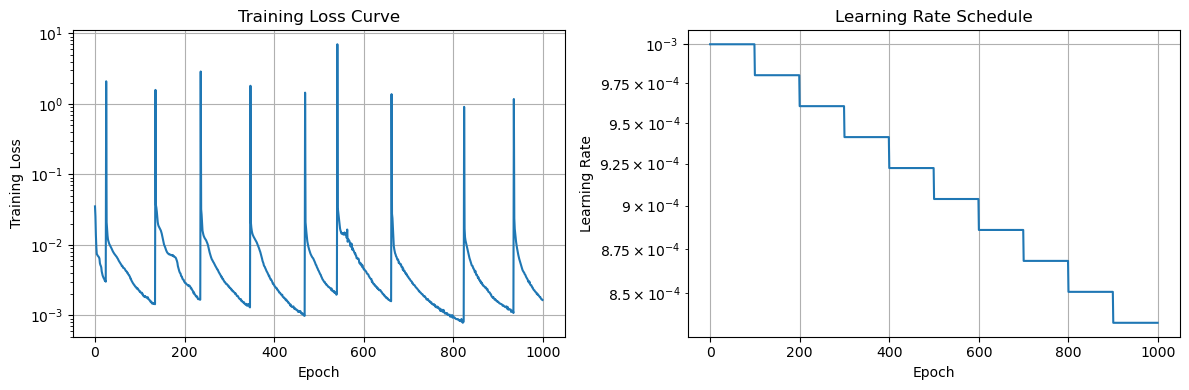

In [41]:
# 创建保存目录
save_dir = './deeponet_results/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created save directory: {save_dir}")

# 保存模型
model_path = os.path.join(save_dir, 'deeponet_burgers.pth')
trainer.save_model(model_path)

# 绘制训练曲线
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 2, 1)
plt.semilogy(trainer.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.grid(True)

# 学习率曲线
plt.subplot(1, 2, 2)
plt.semilogy(trainer.lr_history)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## 8. 测试集性能评估

在测试集上全面评估模型性能。

Evaluating 200 test samples...
Processed 50/200 samples


Processed 100/200 samples
Processed 150/200 samples
Processed 200/200 samples

Test Set Performance Statistics:
Mean Relative L2 Error: 3.0472e-01
Std Relative L2 Error:  3.7752e-01
Max Relative L2 Error:  4.3067e+00
Min Relative L2 Error:  1.3268e-01


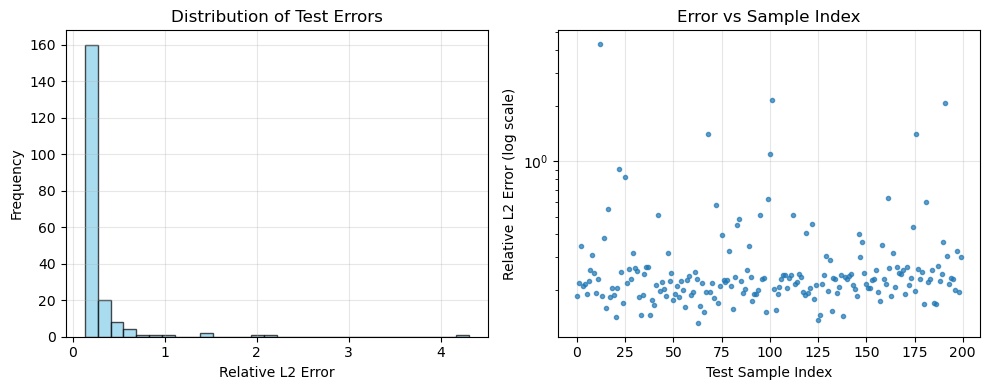

In [42]:
# 评估所有测试样本的性能
n_test_samples = len(trainer.data_loader.test_initial_conditions)
test_errors = []

print(f"Evaluating {n_test_samples} test samples...")

for i in range(n_test_samples):
    error = trainer.evaluate(sample_index=i)
    test_errors.append(error)
    
    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{n_test_samples} samples")

test_errors = np.array(test_errors)

# 统计结果
print(f"\nTest Set Performance Statistics:")
print(f"Mean Relative L2 Error: {test_errors.mean():.4e}")
print(f"Std Relative L2 Error:  {test_errors.std():.4e}")
print(f"Max Relative L2 Error:  {test_errors.max():.4e}")
print(f"Min Relative L2 Error:  {test_errors.min():.4e}")

# 绘制误差分布
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(test_errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Relative L2 Error')
plt.ylabel('Frequency')
plt.title('Distribution of Test Errors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(test_errors, 'o', markersize=3, alpha=0.7)
plt.xlabel('Test Sample Index')
plt.ylabel('Relative L2 Error (log scale)')
plt.title('Error vs Sample Index')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'test_errors.png'), dpi=300, bbox_inches='tight')
plt.show()

## 9. 可视化预测结果

定义可视化函数，展示真实解、预测解和绝对误差的对比。

In [43]:
def visualize_prediction(trainer, sample_index, save_path=None):
    """
    Visualize DeepONet prediction results
    
    Args:
        trainer: DeepONet trainer object
        sample_index: Test sample index
        save_path: Path to save the figure (optional)
    """
    trainer.model.eval()
    
    with torch.no_grad():
        # Get test data
        initial_conditions, coordinates, true_solutions = trainer.data_loader.get_test_data(sample_index)
        
        # Move data to device and predict
        initial_conditions_tensor, coordinates_tensor = trainer._to_device(
            initial_conditions, coordinates
        )
        
        # Prediction
        predictions = trainer.model(initial_conditions_tensor, coordinates_tensor)
        predictions = predictions.cpu().numpy()
        
        # Calculate relative error
        relative_error = (
            np.linalg.norm(predictions - true_solutions) / 
            np.linalg.norm(true_solutions)
        )
        
        print(f"Sample {sample_index} - Relative L2 Error: {relative_error:.4e}")
        
        # Reshape for visualization (101x101 grid)
        true_solution_2d = true_solutions.reshape(101, 101)
        predicted_solution_2d = predictions.reshape(101, 101)
        absolute_error_2d = np.abs(predictions - true_solutions).reshape(101, 101)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Common color limits for better comparison
        vmin = min(true_solutions.min(), predictions.min())
        vmax = max(true_solutions.max(), predictions.max())
        
        # True solution
        im1 = axes[0].imshow(true_solution_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet', 
                            vmin=vmin, vmax=vmax)
        axes[0].set_xlabel('Time t')
        axes[0].set_ylabel('Space x')
        axes[0].set_title('True Solution')
        plt.colorbar(im1, ax=axes[0], shrink=0.8)
        
        # Predicted solution
        im2 = axes[1].imshow(predicted_solution_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet', 
                            vmin=vmin, vmax=vmax)
        axes[1].set_xlabel('Time t')
        axes[1].set_ylabel('Space x')
        axes[1].set_title('DeepONet Prediction')
        plt.colorbar(im2, ax=axes[1], shrink=0.8)
        
        # Absolute error
        im3 = axes[2].imshow(absolute_error_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet')
        axes[2].set_xlabel('Time t')
        axes[2].set_ylabel('Space x')
        axes[2].set_title(f'Absolute Error\n(Rel. L2: {relative_error:.2e})')
        plt.colorbar(im3, ax=axes[2], shrink=0.8)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
    
    trainer.model.train()

## 10. 展示多个测试样本的预测结果

选择具有代表性的测试样本，展示DeepONet的预测效果。

Generating prediction visualizations...


=== Test Sample 0 ===
Sample 0 - Relative L2 Error: 1.8605e-01


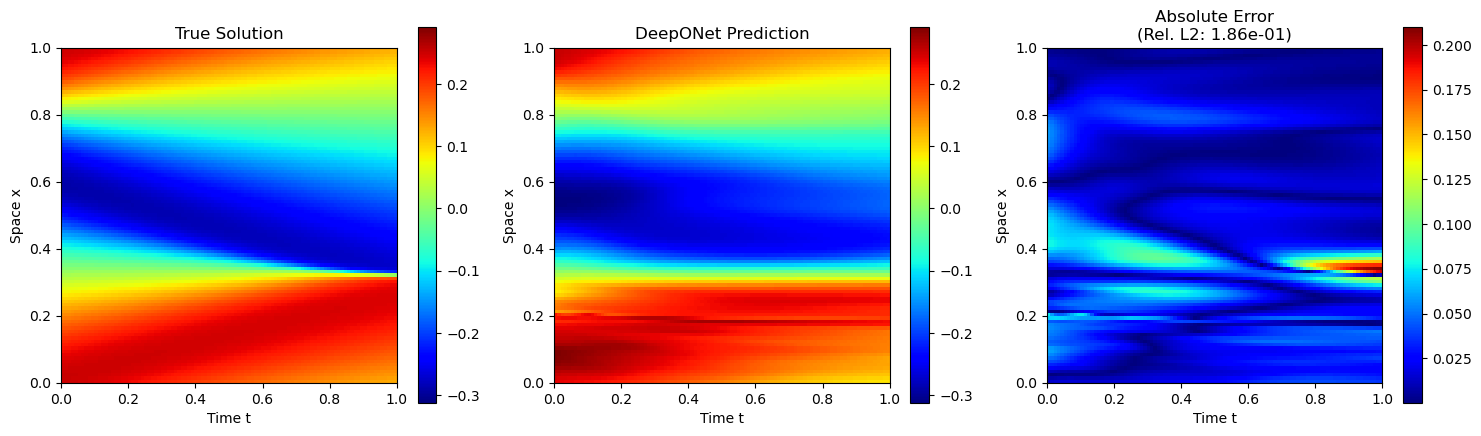


=== Test Sample 5 ===
Sample 5 - Relative L2 Error: 1.9032e-01


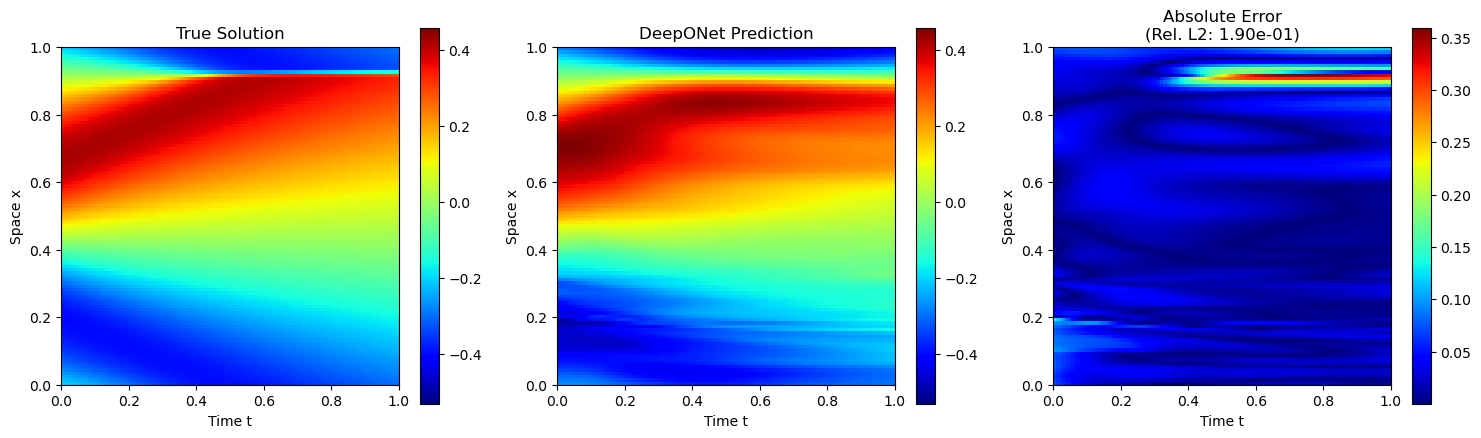


=== Test Sample 10 ===
Sample 10 - Relative L2 Error: 1.9284e-01


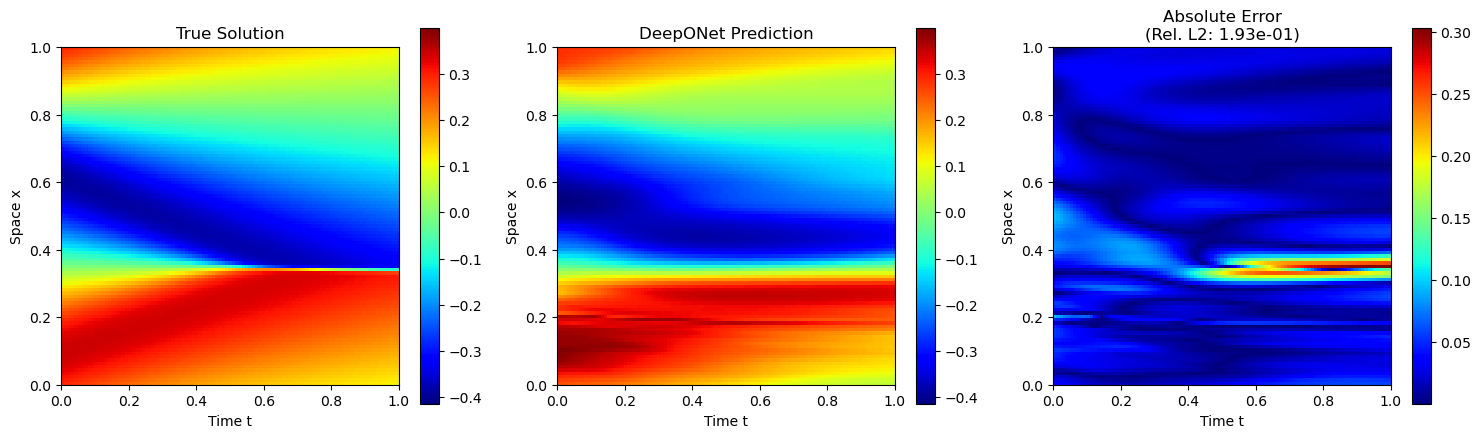


=== Test Sample 15 ===
Sample 15 - Relative L2 Error: 1.6061e-01


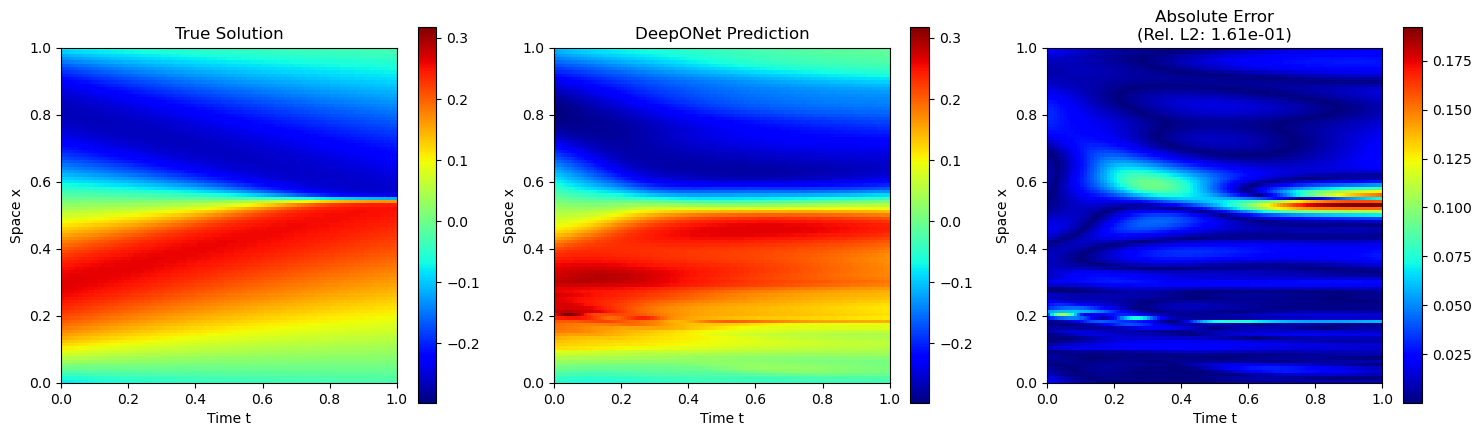


=== Test Sample 25 ===
Sample 25 - Relative L2 Error: 8.2467e-01


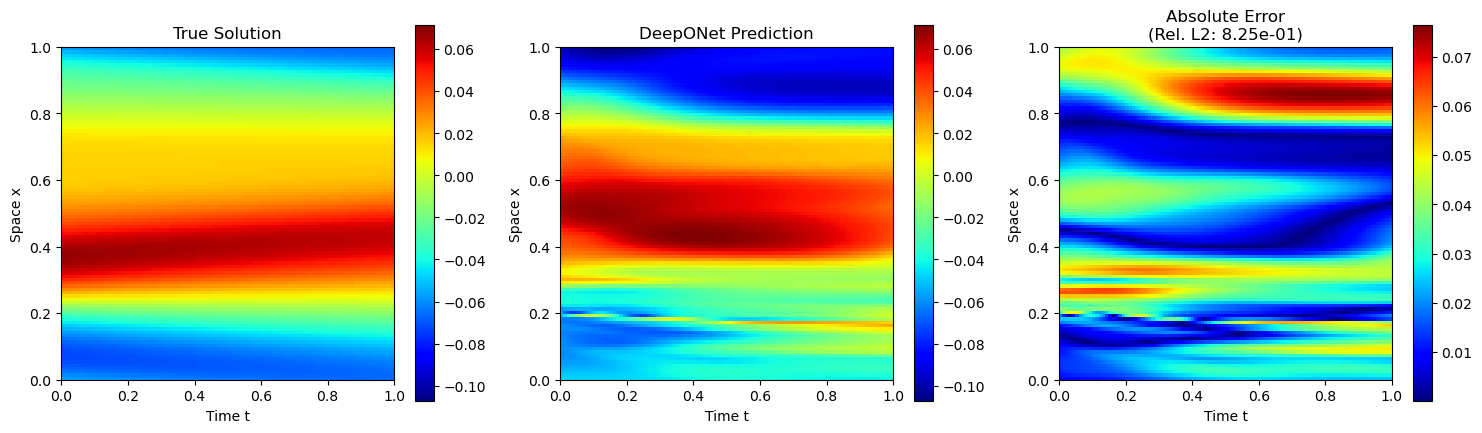


=== Test Sample 50 ===
Sample 50 - Relative L2 Error: 1.7672e-01


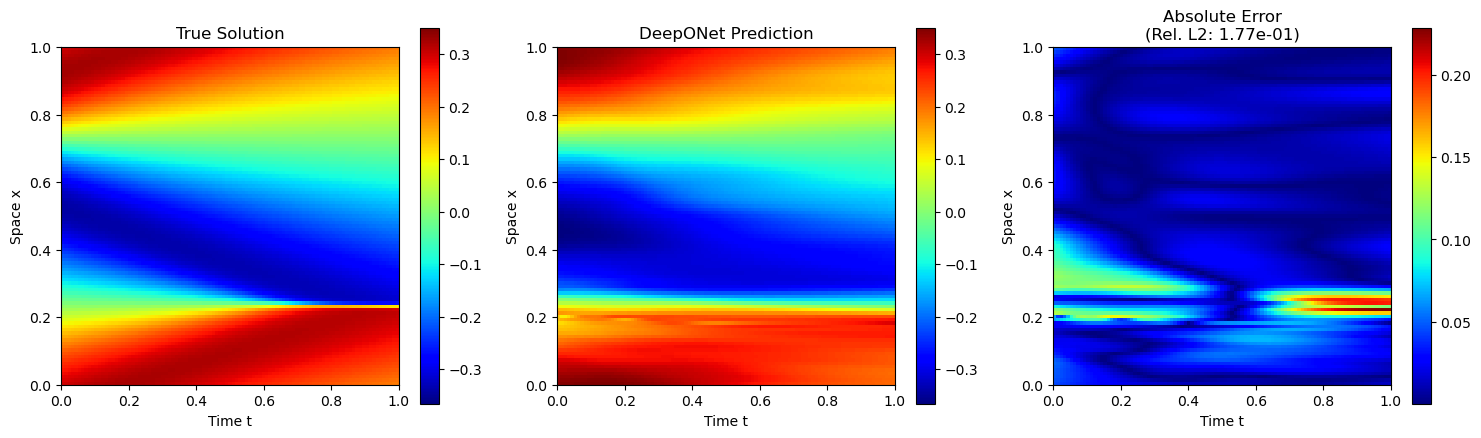

In [44]:
# 选择要可视化的测试样本
sample_indices = [0, 5, 10, 15, 25, 50]

print("Generating prediction visualizations...\n")

for idx in sample_indices:
    if idx < len(trainer.data_loader.test_initial_conditions):
        print(f"\n=== Test Sample {idx} ===")
        save_path = os.path.join(save_dir, f'prediction_sample_{idx}.png')
        visualize_prediction(trainer, idx, save_path)
    else:
        print(f"Sample {idx} is out of range (max: {len(trainer.data_loader.test_initial_conditions)-1})")

## 11. 加载预训练模型进行测试

演示如何加载已保存的模型进行推理。

In [45]:
# 创建新的训练器实例用于测试
test_trainer = DeepONetTrainer(
    branch_input_dim=101,
    trunk_input_dim=2,
    hidden_dim=100,
    num_hidden_layers=6,
    output_dim=100
)

# 加载预训练模型
model_path = './deeponet_results/deeponet_burgers.pth'
if os.path.exists(model_path):
    test_trainer.load_model(model_path)
    print("Pretrained model loaded successfully!")
    
    # 快速测试
    test_error = test_trainer.evaluate(sample_index=0)
    print(f"Test sample 0 - Relative L2 Error: {test_error:.4e}")
else:
    print("No pretrained model found. Please train the model first.")

Using device: cuda
Loading Burgers equation dataset...


Training samples: 1000
Test samples: 200
Grid points per sample: 10201
Model loaded from ./deeponet_results/deeponet_burgers.pth
Pretrained model loaded successfully!
Test sample 0 - Relative L2 Error: 1.8605e-01


/tmp/ipykernel_3665776/3584408954.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=self.device)


## 总结

本notebook成功实现了标准的DeepONet架构用于求解Burgers方程。与物理信息版本的主要区别包括：

### 网络架构特点
- **分支网络**: 处理函数输入(初始条件)，将101维输入映射到100维特征空间
- **主干网络**: 处理坐标输入(时空点)，将2维坐标映射到100维特征空间
- **输出合成**: 通过点积操作和偏置项组合两个网络的输出

### 训练方法
- **纯监督学习**: 完全基于输入-输出数据对进行训练
- **无物理约束**: 不需要计算偏微分方程残差
- **数据驱动**: 依赖高质量的训练数据学习算子映射

### 优势
- **训练简单**: 标准的监督学习流程，易于实现和调试
- **计算效率**: 无需计算高阶导数，训练速度更快
- **通用性强**: 适用于各种算子学习任务

### 局限性
- **数据依赖**: 需要大量高质量的训练数据
- **泛化能力**: 在训练数据覆盖范围外的泛化能力可能有限
- **物理一致性**: 不能保证预测结果严格满足物理定律

该实现展示了DeepONet在函数到函数映射学习中的强大能力，为科学计算和工程应用提供了高效的数据驱动解决方案。